# Effector Prediction using Machine Learning #

The aim of this notebook is to create a basic machine learning model using scikit.learn that can predicted whether or not a given protein is an effector from the amino acid sequence. The purpose of creating this notebook is to improve my understanding of implementing machine learning for practical applications in bioinformatics. I recommend that EffectorP (previously published machine learning effector prediction software) is used for effector prediction and not this notebook. 

## Basic Method Outline ###

1) Take effector and non-effector sequences, extract the following information;
* Size of protein
* Identity & position of first 22 amino acids
* Presence of an LxxR cleavage motif in the first 75 amino acids
2) Create dataframe with above information and use it to train a machine learning decision tree model
3) Use a test dataset not used to train the model to determine the accuracy of the  machine learning model. 

## Dataset Preparation ##

The first cell imports the required packages for preparing the data before it can be used to train a machine learning model.

The second cell contains the functions required to prepare the data.

The third cell requires the location of the fasta file the user wants to use for training and the fasta file the user wants to use for testing the model. The input fasta files must have the effector sequences first followed by the non-effector sequences, the user must also specify how many of the sequences are effectors.

In [7]:
# Imports required for data preparation
import re, pandas as pd

In [2]:
def sequence_extraction(file_location):
    '''Extracts the amino acid sequence for each protein in the given fasta file. 
    The code below collects the names of the sequences which can also be returned 
    and used elsewhere if desired'''
    names = []
    sequences = []
    temp_protein = ""
    with open(file_location, "r") as open_file:
        for line in open_file:
            if line[0] == '>':
                names.append(line[1:-1])
                sequences.append(temp_protein)
                temp_protein = ""
            else:
                temp_protein += line[:-1]
    sequences.append(temp_protein)
    sequences.pop(0)
    return sequences

def sequence_analysis(sequences):
    '''Determines all the information that is later used to train the machine learning model.
    This includes the length of the sequence, whether or not there is an LxxR cleavage motif
    in the first 75 amino acids, and what amino acids are present at the N-terminus (first 22
    amino acids). As the machine learning algorithm requires float inputs we later convert the 
    amino acid letter to a corresponding number (see cell below).'''
    amino_acid = {'pos_1':[],'pos_2':[],'pos_3':[],'pos_4':[],'pos_5':[],'pos_6':[],'pos_7':[],'pos_8':[],
             'pos_9':[],'pos_10':[],'pos_11':[],'pos_12':[],'pos_13':[],'pos_14':[],'pos_15':[],
              'pos_16':[],'pos_17':[],'pos_18':[],'pos_19':[],'pos_20':[],'pos_21':[],'pos_22':[]}
    lengths = []
    LxxR = []
    cleavage_site = []
    LxxR_motif = re.compile('L..R')
    for sequence in sequences:
        lengths.append(len(sequence))
        Kex2 = LxxR_motif.search(sequence[0:50])
        Kex2 = str(Kex2)
        cleavage_site.append(Kex2)
        counter = 1
        for letter in sequence:
            if counter <= 22:
                amino_acid['pos_'+str(counter)].append(letter)
                counter += 1
            else:
                continue
    for element in cleavage_site:
        if element != 'None':
            LxxR.append(1)
        else:
            LxxR.append(0)
    return amino_acid, lengths, LxxR

def effector_classification(number_of_effectors, number_of_sequences):
    effector = []
    for i in range(number_of_sequences):
        if i <= number_of_effectors-1:
            effector.append(1)
        else:
            effector.append(0)
    return effector

In [3]:
# Provide the location for the training sequences and the test sequences. 
# In both files the known effector sequences must come first followed by
# the non-effectors.
training_sequences = sequence_extraction('training_effectors.fasta')
test_sequences = sequence_extraction('test_effectors.fasta')
# Calling the functions
amino_acid_training, training_lengths, training_lxxr = sequence_analysis(training_sequences)
amino_acid_test, test_lengths, test_lxxr = sequence_analysis(test_sequences)
# The user needs to provide the number of effector sequences in each fasta file
training_effectors = effector_classification(94, len(training_lxxr))
test_effectors = effector_classification(21, len(test_lxxr))
# Collating the data and storing it as a dataframe
training_data = pd.DataFrame.from_dict(amino_acid_training)
training_data.insert(0,'Length', training_lengths)
training_data.insert(0,'LxxR', training_lxxr)
training_data.insert(24,'Effector', training_effectors)
test_data = pd.DataFrame.from_dict(amino_acid_test)
test_data.insert(0,'Length', test_lengths)
test_data.insert(0,'LxxR', test_lxxr)
test_data.insert(24,'Effector', test_effectors)
# As the machine learning algorithm requires floats (and does not work with
# strings), the code below replaces all amino acid letters in the dataframes
# with a coresponding number. These numbers are important to remember when
# trying to interpret the decision tree at the end of this notebook. 
test_data.replace({'A':1,'R':2,'N':3,'D':4,'C':5,'E':6,'Q':7,'G':8,
                   'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,'P':15,
                  'S':16,'T':17,'W':18,'Y':19, 'V':20}, inplace = True)
training_data.replace({'A':1,'R':2,'N':3,'D':4,'C':5,'E':6,'Q':7,'G':8,
                   'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,'P':15,
                  'S':16,'T':17,'W':18,'Y':19, 'V':20}, inplace = True)
# Saving the training and test datasets to csv files 
training_data.to_csv('training_dataset.csv', index = False)
test_data.to_csv('test_dataset.csv', index = False)

## Model Training ##

The first cell imports the required packages for training a machine learning model, making a prediction using the trained model, assessing the accuracy of that prediction, saving the model file and the decision tree the model uses, and viewing the decision tree in the notebook.

The second cell trains, assesses the model, and saves the model. 

The third cell saves the decision tree used by the model and displays it in the viewport for the user to inspect. 

In [ ]:
# Imports required for training and assessing the machine learning model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import joblib
from sklearn import tree
import graphviz

In [5]:
# The rows in the dataframes are shuffled. 
# This is important as the dataframes had all the effectors 
# at the top which may lead to unwanted bias in the model.
training_data = shuffle(training_data)
test_data = shuffle(test_data)
# Separating the data into inputs (X) and outputs/predictions (y).
X_train = training_data.drop(columns = ['Effector'])
y_train = training_data['Effector']
X_test = test_data.drop(columns = ['Effector'])
y_test = test_data['Effector']
# Training the model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
# Making predictions
predictions = model.predict(X_test) 
# Determining how accurate the predictions were
score = accuracy_score(y_test, predictions)
# Adding the prediction as a final column to the test dataset, 
# this can be manually inspected to 
test_data.insert(25, column='Prediction', value=predictions)
# Saving the model
joblib.dump(model, 'effector_ml_model')
# Printing the accuracy score for the user to see
print('The model is '+str(score*100)+'% accurate')

The model is 90.56603773584906% accurate


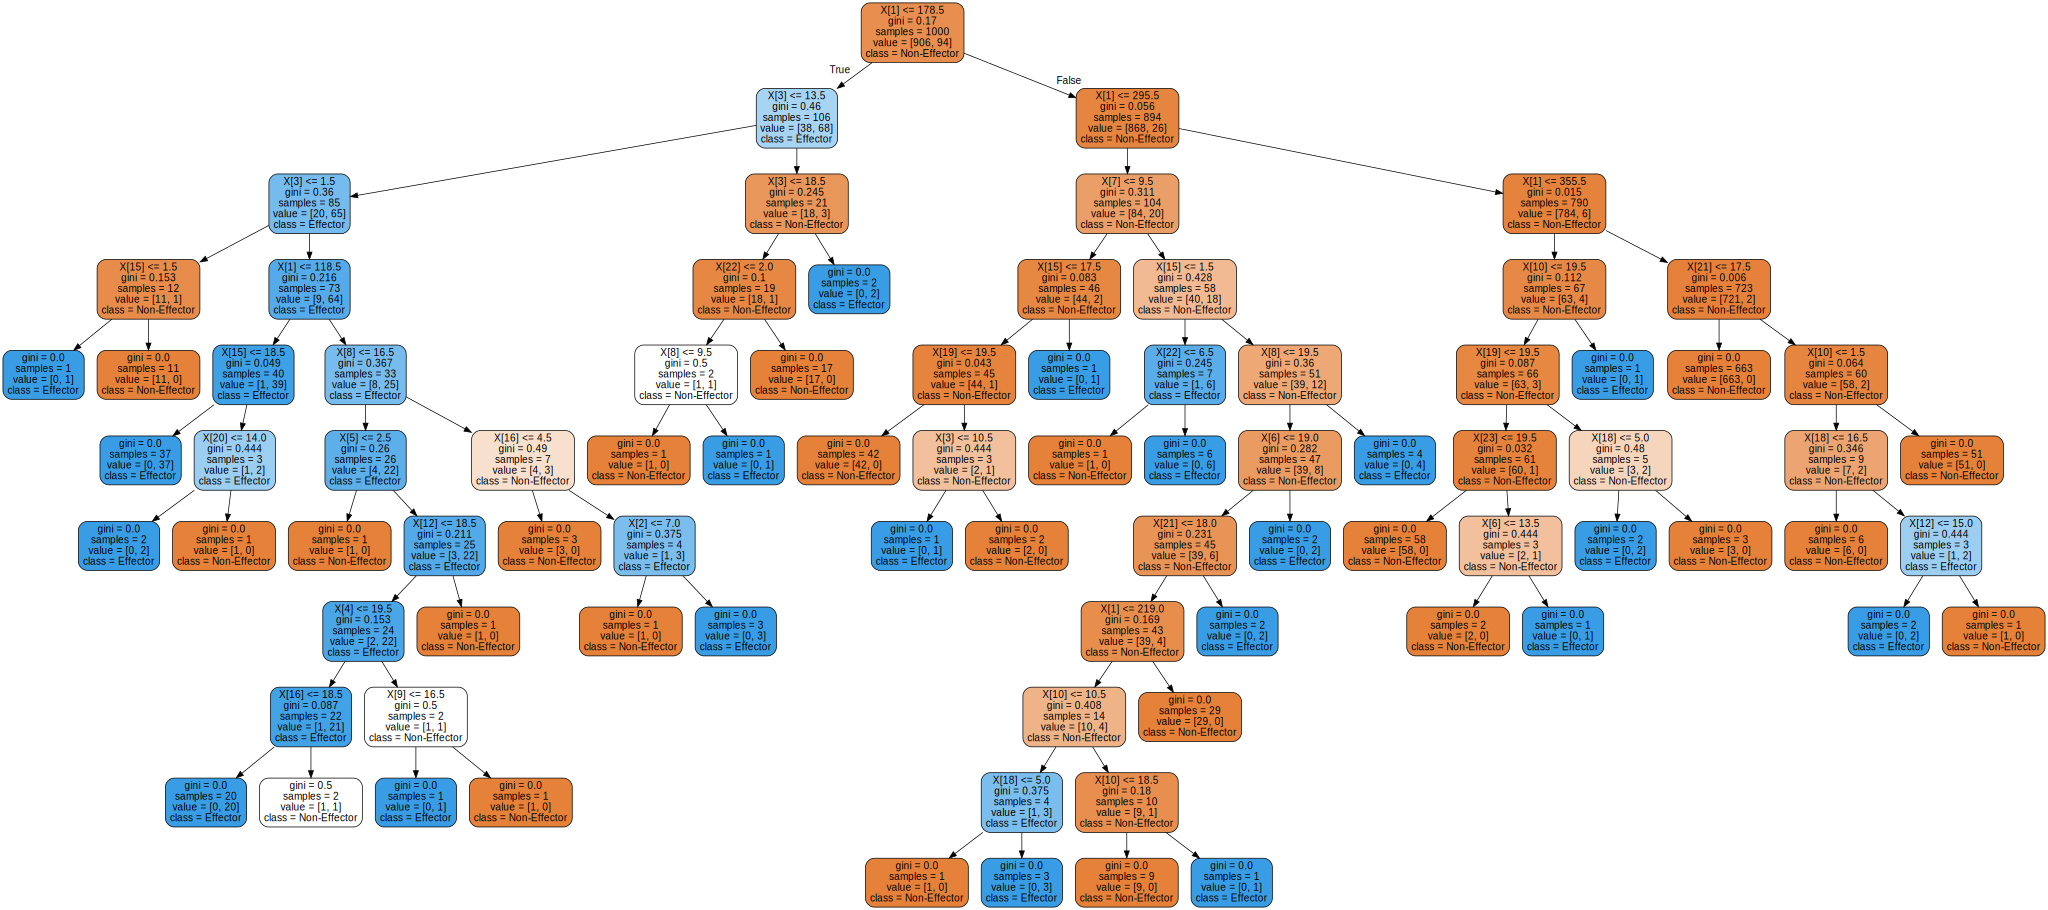

In [6]:
# Saving and viewing the decision tree that the model uses to make predictions
tree.export_graphviz(model, out_file='effector_decision_tree.dot', label='all', rounded=True,filled=True, class_names = ['Non-Effector', 'Effector'])
with open("effector_decision_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## How to improve the Model ##

The model created here to predict effectors appears to be very accurate (~ 90%). However analysis of the decision tree indicates that the most important factor for deciding if a protein is an effector or not is the size of the protein. This would likely lead to many false positives on small non-effector proteins. More small non-effector proteins should be included in the training and the test set to help prevent and detect this. Whether or not a protein has an LxxR cleavage motif has no impact on whether or not a protein is classified as an effector, indicating that the presence of this motif is just as prevalent in non-effectors as it is in effectors. To better identify LxxR effectors the model could be given information on the secondary structure of the protein sequence prior to the LxxR sequence. Potentially another way to improve the model would be to give similar amino acids in the N-terminus the same number or to order the numbers given to each amino acid as an identifier in a more meaningful way (i.e. starting at 1 first list the positive amino acids, then the polar non-charged amino acids, the negative amino acids, the non-polar amino acids (ending with the large aromatic non-polar amino acids). 